In [463]:
import numpy as np

In [464]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))

## 1.1 ##

In [465]:
sigma = 0.30
a = 0.05
deltat = 1/12
V = sigma**2 * (1-np.exp(-2*a*deltat))/(2*a)
deltau = np.sqrt(3*V)
numMonths = 24
P = lambda x: np.e**(-0.06 * x * deltat)

In [466]:
OU = np.zeros((numMonths*2 + 1,numMonths))

In [467]:
for i in range(int(numMonths)):
    index1 = int(numMonths - i - 1)
    index2 = int(numMonths + i + 1)
    OU[index1][:] = (i+1) * deltau
    OU[index2][:] = -(i+1) * deltau

## 1.2 ##

In [468]:
intermediateParams = np.zeros((numMonths*2 + 1, 6))

In [469]:
intermediateParams[:,0] = np.arange(numMonths, -numMonths-1,-1)
intermediateParams[:,1] = np.arange(numMonths, -numMonths-1,-1)

In [470]:
for i in range(numMonths*2 + 1):
    intermediateParams[i,2] = intermediateParams[i,0] * np.exp(-a * deltat) - intermediateParams[i,1]

In [471]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,3] = 1/6 + 1/2*(Beta**2 + Beta)

In [472]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,4] = 2/3 - Beta**2

In [473]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,5] = 1/6 + 1/2*(Beta**2 - Beta)

## 1.3 ##

In [479]:
AD = np.zeros((numMonths*2 + 1,numMonths))
AD[numMonths,0] = 1

In [480]:
r = np.zeros((numMonths*2 + 1, numMonths))
r[numMonths,0] = -np.log(P(1))/(1/12)

In [481]:
from sympy import symbols, Eq, solve, lambdify

for i in range(1,numMonths):
#for i in range(1,2):
    
    r0 = symbols('r0')
    P_sumAD = 0
    P_sumAD = -P(i) + AD[numMonths,i-1]*np.e**(-r0*deltat)*intermediateParams[numMonths,4] + AD[numMonths+1,i-1]*np.e**(-r0*deltat)*intermediateParams[numMonths,3] + AD[numMonths-1,i-1]*np.e**(-r0*deltat)*intermediateParams[numMonths,5]
    
    for j in range(i):
        
        Pd_down_iter = intermediateParams[numMonths + j,5]
        Pm_down_iter = intermediateParams[numMonths + j,4]
        Pu_down_iter = intermediateParams[numMonths + j,3]
        
        Pd_up_iter = intermediateParams[numMonths - j,5]
        Pm_up_iter = intermediateParams[numMonths - j,4]
        Pu_up_iter = intermediateParams[numMonths - j,3]
        
        #find one step forward Arrow-Debreu Prices
        AD[numMonths - j - 1, i ] = AD[numMonths - j , i - 1 ]*Pd_up_iter*np.exp(-r[numMonths - j, i - 1]*deltat) + AD[numMonths - j - 1, i - 1 ]*Pm_up_iter*np.exp(-r[numMonths - j - 1, i - 1]*deltat) + AD[numMonths - j - 2, i - 1 ]*Pu_up_iter*np.exp(-r[numMonths - j - 2, i - 1]*deltat)
        AD[numMonths, i ] = AD[numMonths + 1, i-1]*intermediateParams[numMonths,5]*np.exp(-r[numMonths + 1, i - 1]*deltat) + AD[numMonths, i-1]*intermediateParams[numMonths,4]*np.exp(-r[numMonths , i - 1]*deltat) + AD[numMonths +1, i-1]*intermediateParams[numMonths,3]*np.exp(-r[numMonths + 1, i - 1]*deltat)
        AD[numMonths + j + 1, i ] = AD[numMonths + j , i - 1 ]*Pd_down_iter*np.exp(-r[numMonths + j, i - 1]*deltat) + AD[numMonths + j + 1, i - 1 ]*Pm_down_iter*np.exp(-r[numMonths + j + 1, i - 1]*deltat) + AD[numMonths + j + 2, i - 1 ]*Pu_down_iter*np.exp(-r[numMonths + j + 2, i - 1]*deltat)   
        
    #update r values for one step ahead
    for j in range(i):
        # if i-j == 1
        if i-j == 1:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        # if i-j == 2
        if i-j == 2:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j,5]

            P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
            P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4]

        # if i-j == 3
        if i-j == 3:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j,5]

            P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
            P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4] 

            P_sumAD += AD[numMonths-j-2,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-2,i-1])*deltat)*intermediateParams[numMonths-j-2,5]
            P_sumAD += AD[numMonths+j+2,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+2,i-1])*deltat)*intermediateParams[numMonths+j+2,3]
      
    eq1 = Eq(P_sumAD)
    convert = lambdify('r0',P_sumAD)
    sol_r = convert(0)
    
    #update ri(0)
    r[numMonths, i] = sol_r                                              
    #update r matrix based off ri(0) * exp(OUij)
    for j in range(i):
        r[numMonths + j + 1 , i ] = r[numMonths, i] * np.exp(OU[numMonths + j + 1, i])
        r[numMonths - j - 1 , i ] = r[numMonths, i] * np.exp(OU[numMonths - j - 1, i])

In [482]:
r

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -17.4],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -15.3, -15],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -13.4, -13.1, -12.9],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -11.7, -11.5, -11.3, -11.1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10.3, -10.1, -9.93, -9.74, -9.56],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -9, -8.85, -8.7, -8.55, -8.39, -8.23],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -7.87, -7.75, -7.62, -7.49, -7.36, -7.22, -7.09],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -6.88, -6.78, -6.67, -6.56, -6.45, -6.34, -6.22, -6.1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -6.01, -5.93, -5.84, -5.74, -5.65, -5.55, -5.45, -5.35, -5.25],
       [0, 0, 0, 

## 2.b ##

In [483]:
from sympy import symbols , Eq, solve, diff, sqrt, simplify, evalf, log, exp
k = symbols('k')
T = symbols('T')
t = symbols('t')
h = sqrt(k**2 + 2*s**2)
o = symbols('o')
s = symbols('s')
r = symbols('r')

In [484]:
A = ((2*h * exp((T-t)*(k+h)/2))/(2*h + (k+h)*(exp((T-t)*h)-1)))**(2*k*o/(s**2))
A_prime = diff(A,t)

In [485]:
A

(2*sqrt(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2)))**(2*k*o/s**2)

In [486]:
(A_prime)

k*o*(2*sqrt(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2)))**(2*k*o/s**2)*((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))*(2*(-k/2 - sqrt(k**2 + 2*s**2)/2)*sqrt(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2)) + 2*(k + sqrt(k**2 + 2*s**2))*(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)*exp((T - t)*sqrt(k**2 + 2*s**2))/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))**2)*exp(-(T - t)*(k + sqrt(k**2 + 2*s**2))/2)/(s**2*sqrt(k**2 + 2*s**2))

In [487]:
B = (2 * (exp((T-t)*h)-1)) / (2*h + (k + h)*(exp((T-t)*h) - 1))
B_prime = diff(B,t)

In [488]:
B

(2*exp((T - t)*sqrt(k**2 + 2*s**2)) - 2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))

In [489]:
B_prime

(k + sqrt(k**2 + 2*s**2))*sqrt(k**2 + 2*s**2)*(2*exp((T - t)*sqrt(k**2 + 2*s**2)) - 2)*exp((T - t)*sqrt(k**2 + 2*s**2))/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))**2 - 2*sqrt(k**2 + 2*s**2)*exp((T - t)*sqrt(k**2 + 2*s**2))/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))

In [501]:
print(simplify(A_prime - k*o*B*A) == 0)
print(simplify(B_prime + 1 - (1/2*(s**2)*B**2 + k*B))==0)

True
True


In [502]:
#terminal condition on A
convert = lambdify( ['k','T','t','o','s','r'], A)
sol_r = convert(1,30,30,0.03,0.1,0.01)
print(sol_r)

1.0


In [503]:
#terminal condition on B
convert = lambdify( ['k','T','t','o','s','r'], -B_prime + 1/2*(s**2)*(B**2) + k*B - 1)
sol_r = convert(1,0,0,0.03,0.1,0.01)
print(sol_r)

0.0


In [504]:
forwardRate = log(A*exp(-B*r))
forwardRate

log((2*sqrt(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2)))**(2*k*o/s**2)*exp(-r*(2*exp((T - t)*sqrt(k**2 + 2*s**2)) - 2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))))

In [505]:
instantFwdRate = -diff(forwardRate,T)
simplify(instantFwdRate)

instantFwdRateZero = instantFwdRate.subs('t',0)

In [506]:
convert = lambdify( ['k','T','o','s','r'], instantFwdRateZero)

storedValues = []
x = []
for i in range(31):
    x.append(i)
    storedValues.append(convert(1,i,0.03,0.1,0.01))

In [507]:
import seaborn as sns

/Users/sethkelley/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


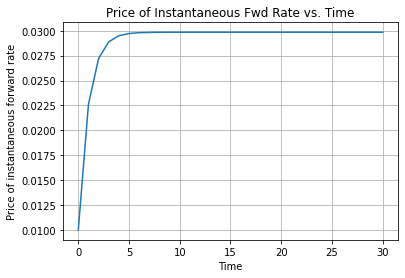

In [508]:
ax = sns.lineplot(x,storedValues)
ax.set(xlabel = 'Time', ylabel = 'Price of instantaneous forward rate',title = "Price of Instantaneous Fwd Rate vs. Time")
ax.grid()

## 2.c

In [720]:
T = 30
N = 1000
terminalA = 1
terminalB = 0
dt = 30/1000
k = 1 
o = 0.03
s = 0.1

In [721]:
A = []
B = []

A.append(terminalA)
B.append(terminalB)

for i in range(N):
    
    insertA = A[0] - dt*(k*o*A[0]*B[0])
    insertB = B[0] + dt - (1/2*(s**2)*(B[0]**2)+k*B[0])*dt
    
    A.insert(0,insertA)
    B.insert(0,insertB)
    
print("The estimated value of A(0,T) is: " ,np.round(A[0],3)) 
print("The estimated value of B(0,T) is: " ,np.round(B[0],3))  

The estimated value of A(0,T) is:  0.421
The estimated value of B(0,T) is:  0.995


In [667]:
Asym = ((2*h * exp((T-t)*(k+h)/2))/(2*h + (k+h)*(exp((T-t)*h)-1)))**(2*k*o/(s**2))
Bsym = (2 * (exp((T-t)*h)-1)) / (2*h + (k + h)*(exp((T-t)*h) - 1))

In [668]:
#terminal condition on A
convert = lambdify( ['k','T','t','o','s','r'], Asym)
A_zero = convert(1,30,0,0.03,0.1,0.01)
print("The actual value of A(o,T) is: ",np.round(A_zero,3))

The actual value of A(o,T) is:  0.421


In [669]:
#terminal condition on B
convert = lambdify( ['k','T','t','o','s','r'], Bsym)
B_zero = convert(1,30,0,0.03,0.1,0.01)
print("The actual value of B(o,T) is: ",np.round(B_zero,3))

The actual value of B(o,T) is:  0.995


In [670]:
print("The error on A is: ",np.abs(A_zero-A[0])/A_zero)
print("The error on A is: ",np.abs(B_zero-B[0])/B_zero)

The error on A is:  0.00038023432859054894
The error on A is:  2.5215874477736136e-14


## 2.d

In [671]:
T = 30
N = 1000
terminalA = 1
terminalB = 0
dt = 30/1000
k = 1 
o = 0.03
s = 0.1

In [672]:
A = []
B = []

A.append(terminalA)
B.append(terminalB)

for i in range(N):
    
    insertB = (-(1 + k*dt) + np.sqrt((1 + k*dt)**2 + 4*(1/2 * dt * (s**2))*(B[0]+dt)))/(dt*(s**2))
    insertA = A[0]/(1 + dt*k*o*insertB)
    
    A.insert(0,insertA)
    B.insert(0,insertB)
    
print("The estimated value of A(0,T) is: " ,np.round(A[0],3)) 
print("The estimated value of B(0,T) is: " ,np.round(B[0],3))  

The estimated value of A(0,T) is:  0.421
The estimated value of B(0,T) is:  0.995


In [673]:
print("The error on A is: ",np.abs(A_zero-A[0])/A_zero)
print("The error on A is: ",np.abs(B_zero-B[0])/B_zero)

The error on A is:  0.0003797631052428798
The error on A is:  1.4015005349658912e-11


## 2.e

In [791]:
T = 30
k = 12
terminalA = 1
terminalB = 0
o = 0.03
k=1
s = 0.1

In [792]:
Ak = []
Bk = []
Akval = []
Bkval = []

for j in range(1,16):
    A = []
    B = []

    A.append(terminalA)
    B.append(terminalB)
    
    insertA = 0 
    insertB = 0
    
    N = 2**j
    dt = T/N

    for i in range(N):
        insertA = A[0] - dt*(k*o*A[0]*B[0])
        insertB = B[0] + dt - (1/2*(s**2)*(B[0]**2)+k*B[0])*dt

        A.insert(0,insertA)
        B.insert(0,insertB)
        
    Akval.append(A[0])
    Bkval.append(B[0])
    Ak.append("for k = {}, A[0,T] is {}".format(j,np.round(A[0],5)))
    Bk.append("for k = {}, B[0,T] is {}".format(j,np.round(B[0],5)))

In [793]:
Ak

['for k = 1, A[0,T] is -5.75',
 'for k = 2, A[0,T] is 356.70171',
 'for k = 3, A[0,T] is 2379830.05181',
 'for k = 4, A[0,T] is 0.40559',
 'for k = 5, A[0,T] is 0.41554',
 'for k = 6, A[0,T] is 0.41814',
 'for k = 7, A[0,T] is 0.41941',
 'for k = 8, A[0,T] is 0.42004',
 'for k = 9, A[0,T] is 0.42035',
 'for k = 10, A[0,T] is 0.42051',
 'for k = 11, A[0,T] is 0.42059',
 'for k = 12, A[0,T] is 0.42063',
 'for k = 13, A[0,T] is 0.42065',
 'for k = 14, A[0,T] is 0.42066',
 'for k = 15, A[0,T] is 0.42066']

In [794]:
Bk

['for k = 1, B[0,T] is -211.875',
 'for k = 2, B[0,T] is -3210.74696',
 'for k = 3, B[0,T] is -159029.9237',
 'for k = 4, B[0,T] is 0.83123',
 'for k = 5, B[0,T] is 0.99505',
 'for k = 6, B[0,T] is 0.99505',
 'for k = 7, B[0,T] is 0.99505',
 'for k = 8, B[0,T] is 0.99505',
 'for k = 9, B[0,T] is 0.99505',
 'for k = 10, B[0,T] is 0.99505',
 'for k = 11, B[0,T] is 0.99505',
 'for k = 12, B[0,T] is 0.99505',
 'for k = 13, B[0,T] is 0.99505',
 'for k = 14, B[0,T] is 0.99505',
 'for k = 15, B[0,T] is 0.99505']

In [797]:
logError = 1/np.log(2) * np.log(np.sqrt(

NameError: name 'e' is not defined